# Helper Function

In [1]:
"""
This module contains all the functions that define the kernels
"""
import numpy as np
import matplotlib.pyplot as plt
import torch

# The quantum kernel with pauli X encoding is identical to this, to speed up computation we used this
def full_kernel_classic(x, y):
    """
    Classical evaluation of the full kernel
    :param x: arg 1
    :param y: arg 2
    :return:
    """
    k = 1
    for i in range(len(x)):
        k = k * np.cos(1/2*(x[i]-y[i]))**2
    return k


def kernel_matrix_classic(X, Y):
    """
    compute the kenel matrix of the full kernel
    :param X: vector of samples
    :param Y: vector of samples
    :return:
    """
    K = np.zeros((len(X), len(Y)))
    for i in range(len(X)):
        for j in range(len(Y)):
            K[i, j] = full_kernel_classic(X[i], Y[j])
    return K


def kernel_matrix_classic_torch(X, Y):
    """
    compute the kenel matrix of the full kernel potentially utilizing some parallel processing
    :param X: vector of samples
    :param Y: vector of samples
    :return:
    """
    if type(X) is np.ndarray:
        X = torch.from_numpy(X)
    if type(Y) is np.ndarray:
        Y = torch.from_numpy(Y)
    # create tensor with entry i x j x k equal to x_ik - y_jk
    X = X.unsqueeze(1).expand(-1, Y.size(0), -1)
    Y = Y.unsqueeze(0).expand(X.size(0), -1, -1)
    K = X - Y
    K = torch.cos(K / 2) ** 2
    K = torch.prod(K, 2)
    return K



In [2]:
import numpy as np

class GaussianProcessRegressor:
    """
    Gaussian Process Regressor for d-dimensional inputs.
    Returns both predictive mean and std if requested.
    """
    def __init__(self, kernel, alpha=1e-5):
        self.kernel = kernel
        self.alpha = alpha
        self.X_train = None
        self.y_train = None
        self.K_inv = None

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        self.X_train = X
        self.y_train = y
        K = self.kernel(X, X)
        K += self.alpha * np.eye(len(X))
        self.K_inv = np.linalg.inv(K)

    def predict(self, X_test, return_std=False):

        X_test = np.array(X_test)
        K_star = self.kernel(X_test, self.X_train)
        y_mean = K_star @ (self.K_inv @ self.y_train)

        if return_std:
            K_star_star = self.kernel(X_test, X_test)
            cov = K_star_star - K_star @ self.K_inv @ K_star.T
            var = np.diag(cov)
            var = np.maximum(var, 0.0)
            y_std = np.sqrt(var)
            return y_mean, y_std
        else:
            return y_mean


In [3]:
from itertools import product

def build_grid(bounds, n_grid):
    """
    Build a uniform grid of points within the given 'bounds'.

    Parameters
    ----------
    bounds : list of (low, high) for each dimension (length d)
    n_grid : int
        Number of grid points per dimension.

    Returns
    -------
    X_grid : np.ndarray of shape (n_grid^d, d)
        All points in the grid.
    """
    # For each dimension, create an array of n_grid points from low to high
    axes = [np.linspace(low, high, n_grid) for (low, high) in bounds]
    # Cartesian product of all axes
    # e.g. for d=2, we get all pairs (x,y); for d=3, all (x,y,z), etc.
    mesh = list(product(*axes))  # a list of d-tuples
    return np.array(mesh)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from scipy.stats import norm


# EC GP UCB
def gp_ucb_nd(
    f,                 # black-box reward function, shape: (n, d) -> (n,)
    gp,                # a GaussianProcessRegressor instance (fit, predict)
    bounds,            # list of (low, high) for each dimension
    n_iter=10,         # number of UCB iterations
    init_points=3,     # number of initial random samples
    n_grid=50,         # number of grid points per dimension to search for UCB max
    beta_func=None,    # a callable or None => we define a default
    random_state=None,
    error = 1,
    verbose=False
):
    """
    Runs GP-UCB for a multi-armed bandit / Bayesian optimization problem.

    Parameters
    ----------
    f : callable
        The unknown reward function (black-box).
        Input shape (n, d) -> (n,) for n points in dimension d.
    gp : GaussianProcessRegressor
        Surrogate GP model implementing:
          - gp.fit(X, y)
          - gp.predict(X, return_std=True) -> (mean, std)
    bounds : list of (low, high)
        Domain bounding box in d dimensions.
    n_iter : int
        Number of GP-UCB rounds.
    init_points : int
        How many random points to sample initially.
    n_grid : int
        Grid resolution for selecting x_t = argmax_x [mu_{t-1}(x) + sqrt(beta_t)*sigma_{t-1}(x)].
    beta_func : callable or None
        If None, we define a simple default that grows with t.  Otherwise,
        something like:  beta_func(t) -> float
    random_state : int or None
        For reproducibility.
    verbose : bool
        Print iteration details if True.

    Returns
    -------
    regrets : ndarray of shape (n_iter + init_points,)
        Cumulative regret at each iteration (the sum over t=1..T of [f(x*) - f(x_t)]).
    X_samples : ndarray of shape (n_iter + init_points, d)
    Y_samples : ndarray of shape (n_iter + init_points,)

    Notes
    -----
    - We assume we can approximate the global max f(x*) by a dense grid search
      once, for regret calculation.  In a real bandit scenario, you might not
      know x*, but for synthetic tests or known benchmark functions, we do.
    - The domain is searched by a grid of size (n_grid^d).  This is only feasible
      for small d or moderate n_grid.
    """

    if random_state is not None:
        np.random.seed(random_state)

    d = len(bounds)

    # 1) Create a dense grid to:
    #    - approximate x* (the global maximizer)
    #    - search for the UCB argmax each iteration
    X_grid = build_grid(bounds, n_grid=n_grid)  # shape (n_grid^d, d)

    # 2) (Optional) approximate the global maximum for regret calculation
    #    We take the best among the same grid points to get x_star
    Y_grid = f(X_grid)
    idx_best = np.argmax(Y_grid)
    x_star = X_grid[idx_best]
    f_star = Y_grid[idx_best]  # approximate global max value

    # 3) Helper to define a default beta_t if user didn't supply one
    if beta_func is None:
        # E.g. a common choice for finite domain or small bounding
        # can be something like: 2 ln(t^2 * pi^2 / (6 delta))
        # but we just do a simpler scaling of log t for demonstration.
        def beta_func(t):
            return 2.0 * np.log(1000 * t**2 * 10 / 6 / 0.1 )   # delta = 0.1
    # else user supplies something like beta_func(t) => some formula

    # 4) Initialize data by sampling 'init_points' random points
    def sample_random(n):
        return np.array([
            [np.random.uniform(low, high) for (low, high) in bounds]
            for _ in range(n)
        ])

    X_samples = sample_random(init_points)  # shape (init_points, d)
    Y_samples = f(X_samples)               # shape (init_points,)

    # 5) We'll keep track of cumulative regrets
    regrets = np.zeros(n_iter + init_points)
    # First 'init_points' regrets are computed from those random picks
    # Evaluate the regret at each step
    cum_regret = 0.0
    for i in range(init_points):
        cum_regret += (f_star - Y_samples[i])
        regrets[i] = cum_regret

    # 6) Main loop of GP-UCB
    log_sum_for_beta = 0
    for step in range(n_iter):

        X_grid = build_grid(bounds, n_grid=n_grid)

        t = init_points + step + 1  # total iteration index (1-based)

        # Fit GP on current data
        gp.fit(X_samples, Y_samples)

        # Compute mean & std on the entire grid
        mu_grid, std_grid = gp.predict(X_grid, return_std=True)

        # Define current beta_t
        beta_t = 0.1 * (2*np.log(20)+log_sum_for_beta) ** 0.5 + 3

        #beta_func(t)

        # UCB = mu + sqrt(beta_t) * std
        ucb_values = mu_grid + (beta_t + error * np.sqrt(t) ) * std_grid

        # if step % 10 == 0:
        #   print(step)
        #   print(mu_grid[:10], std_grid[:10])
        #   print(ucb_values[:10])
        #   #print(np.max(ucb_values))
        #   print("==========")

        # Argmax on the grid
        idx_next = np.argmax(ucb_values)
        x_next = X_grid[idx_next].reshape(1, -1)

        log_sum_for_beta += np.log(1 + std_grid[idx_next])

        #print(beta_t + error * np.sqrt(t) )
        #print(std_grid[idx_next])

        # Evaluate the unknown function f (bandit feedback)
        np.random.seed(None)
        noise = np.random.normal(0, 0.1)
        y_true = f(x_next)
        y_next = y_true + noise
        #print(noise)

        # Update data
        X_samples = np.vstack([X_samples, x_next])
        Y_samples = np.concatenate([Y_samples, y_next])

        # Update cumulative regret
        cum_regret += (f_star - y_true[0])
        regrets[init_points + step] = cum_regret

        if verbose:
            print(f"Iteration {step+1}/{n_iter}, t={t}, beta={beta_t:.3f}, "
                  f"x_next={x_next[0]}, f(x)={y_next[0]:.4f}, UCB={ucb_values[idx_next]:.4f}, "
                  f"CumReg={cum_regret:.4f}")

    return regrets, X_samples, Y_samples





import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange

def run_multiple_experiments_gp_ucb(
    f,
    gp,
    bounds,
    n_runs=5,
    n_iter=10,
    init_points=3,
    n_grid=50,
    beta_func=None,
    random_state=None,
    error = 1,
    verbose=False
):
    """
    Runs the GP-UCB experiment 'n_runs' times, each time creating a new GP instance.
    Returns the average cumulative regret across runs.

    Parameters
    ----------
    f : callable
        The black-box reward function.
    gp_class_factory : callable
        A function that, when called, returns a *new* untrained GaussianProcessRegressor
        (or similar). For example:
          lambda: GaussianProcessRegressor(kernel=RBF(...), alpha=..., optimizer=None)
        We need a fresh GP for each run, so that each run is independent.
    bounds : list of (low, high)
        Domain bounding box.
    n_runs : int
        Number of independent runs to average over.
    n_iter : int
        Number of GP-UCB rounds (not counting the init_points).
    init_points : int
        Number of random initial points in each run.
    n_grid : int
        Grid resolution for argmax search in each run.
    beta_func : callable or None
        If None, use a default log-based. Otherwise a function beta_func(t) -> float.
    random_state : int or None
        For reproducibility. If set, seeds the first run's RNG, then subsequent runs
        will shift the seed.
    verbose : bool
        Whether to print details for each run.

    Returns
    -------
    avg_regret : ndarray of shape (n_iter + init_points,)
        The pointwise average of the cumulative regret across runs.
    regrets_all : ndarray of shape (n_runs, n_iter + init_points)
        The individual run's cumulative-regret curves.
    """

    from copy import deepcopy

    # If we want reproducibility, set base seed
    base_seed = random_state if random_state is not None else None

    # We'll store the regret curve for each run here
    regrets_all = []

    for i in trange(n_runs, desc="GP-UCB Experiments"):
        # For each run, optionally shift the seed
        if base_seed is not None:
            # shift by i to get distinct seeds
            np.random.seed(base_seed + i)

        # Create a fresh GP instance
        gp_model = gp

        # Import or copy the gp_ucb_nd from your previous code snippet:
        regrets, X_samples, Y_samples = gp_ucb_nd(
            f=f,
            gp=gp_model,
            bounds=bounds,
            n_iter=n_iter,
            init_points=init_points,
            n_grid=n_grid,
            beta_func=beta_func,
            random_state=None,  # we've set the seed externally
            error = error,
            verbose=(verbose and i == 0)  # only verbose in the 1st run, e.g.
        )

        regrets_all.append(regrets)

    regrets_all = np.array(regrets_all)  # shape (n_runs, n_steps)
    avg_regret = regrets_all.mean(axis=0)
    std_regret = regrets_all.std(axis=0)
    return avg_regret, regrets_all, std_regret





In [5]:
lst_of_c = np.array([1/8, 1/8,1/8,1/8,1/8,1/8,1/8,
          1/16,1/16,1/16,1/16,1/16,1/16,1/16,1/16,1/16,1/16,1/16,1/16,
          1/32,1/32,1/32,1/32,1/32,1/32,1/32,1/32,
          ])
lst_of_sqrt_c = lst_of_c**0.5

# lst_of_features = [lambda d0,d1,d2: np.cos(d0)/8, lambda d0,d1,d2:np.cos(d1)/8, lambda d0,d1,d2:np.cos(d2)/8,
#             lambda d0,d1,d2:np.cos(d0+d1)/16, lambda d0,d1,d2:np.cos(d0+d2)/16, lambda d0,d1,d2:np.cos(d1+d2)/16,
#             lambda d0,d1,d2:np.cos(d0-d1)/16, lambda d0,d1,d2:np.cos(d0-d2)/16, lambda d0,d1,d2:np.cos(d1-d2)/16,
#             lambda d0,d1,d2:np.cos(d0+d1+d2)/32, lambda d0,d1,d2:np.cos(d0+d1-d2)/32, lambda d0,d1,d2:np.cos(d0-d1+d2)/32, lambda d0,d1,d2:np.cos(d0-d1-d2)/32
#           ]

def feature_map_full(x):
    """
    X: shape (N, 2) where each row is [x1, x2].

    Returns: Phi, shape (N, 5),
             where Phi[i, :] = [1, cos(x1), sin(x1), cos(x2), sin(x2)] for the i-th sample.
    """
    x0,x1,x2 = x[0],x[1],x[2]
    u0,u1,u2,u3 = 1/8,1/8,1/16,1/32

    return np.array([
        u0**0.5 * 1,

        u1**0.5 * np.cos(x0), u1**0.5 * np.sin(x0),
        u1**0.5 * np.cos(x1), u1**0.5 * np.sin(x1),
        u1**0.5 * np.cos(x2), u1**0.5 * np.sin(x2),

        u2**0.5 * np.cos(x0+x1), u2**0.5 * np.sin(x0+x1), u2**0.5 * np.cos(x0-x1), u2**0.5 * np.sin(x0-x1),
        u2**0.5 * np.cos(x0+x2), u2**0.5 * np.sin(x0+x2), u2**0.5 * np.cos(x0-x2), u2**0.5 * np.sin(x0-x2),
        u2**0.5 * np.cos(x1+x2), u2**0.5 * np.sin(x1+x2), u2**0.5 * np.cos(x1-x2), u2**0.5 * np.sin(x1-x2),

        u3**0.5 * np.cos(x0+x1+x2), u3**0.5 * np.sin(x0+x1+x2),
        u3**0.5 * np.cos(x0+x1-x2), u3**0.5 * np.sin(x0+x1-x2),
        u3**0.5 * np.cos(x0-x1+x2), u3**0.5 * np.sin(x0-x1+x2),
        u3**0.5 * np.cos(x0-x1-x2), u3**0.5 * np.sin(x0-x1-x2)
    ])


def reduced_kernel_classic(x, y, dim=27,seed=None):
    """
    Classical evaluation of the full kernel
    :param x: arg 1
    :param y: arg 2
    :return:
    """
    x_feats = feature_map_full(x)
    y_feats = feature_map_full(y)
    rng = np.random.default_rng(seed)
    x_feats = rng.permutation(x_feats)[:dim]       # returns a new NumPy array
    rng = np.random.default_rng(seed)
    y_feats = rng.permutation(y_feats)[:dim]

    return np.sum(x_feats * y_feats)


def reduced_matrix_classic(X, Y, dim=27,seed=None):
    """
    compute the kenel matrix of the full kernel
    :param X: vector of samples
    :param Y: vector of samples
    :return:
    """
    #print(dim)

    K = np.zeros((len(X), len(Y)))
    for i in range(len(X)):
        for j in range(len(Y)):
            K[i, j] = reduced_kernel_classic(X[i], Y[j],dim,seed=seed)
    return K

In [7]:
# bounds = [(0, 2*np.pi), (0, 2*np.pi),(0, 2*np.pi)]
# X_grid = build_grid(bounds, n_grid=3)
# for i in range(1,28,2):
#   print(i)
#   print(kernel_matrix_classic(X_grid,X_grid)[10,10] - reduced_matrix_classic(X_grid,X_grid,i,seed=1)[10,10])

1
0.875
3
0.75
5
0.71875
7
0.71875
9
0.625
11
0.5625
13
0.53125
15
0.53125
17
0.40625
19
0.28125
21
0.09375
23
0.09375
25
0.03125
27
0.0


In [ ]:

sigma_w = 0.5
w_random = np.random.normal(loc=0.0, scale=sigma_w, size=27)
#w_random = np.array([1,1,1,1,1,1,1,1,1])
#w_random[7],w_random[8] = 1,1
print(w_random)

def f_draw_from_GP(x):
    """A random draw from the GP prior with feature map phi, weights ~ N(0, sigma^2 I)."""
    Phi = feature_map_full(x)
    return np.sum(Phi * w_random)

[ 0.07784249  0.8679078   0.45826619 -0.39247771 -0.25382627  0.57773621
 -0.28652672  0.6117282   0.04868803 -0.57692328 -0.59624458  0.13583791
  0.03074755  0.0271925  -0.11592345  0.66163208  0.76904594 -0.30106644
  0.17293934 -0.44747102 -0.15553136  0.64529628  0.45902313 -0.28505012
 -0.5793214  -0.93886059 -0.41109297]


In [ ]:
# x = [0,0.44,-1]
# y = [-3,2,0.3]
# full_kernel_classic(x,y)

# sum(feature_map_full(x) * feature_map_full(y))
# w_random = np.random.normal(loc=0.0, scale=sigma_w, size=27)
# f_draw_from_GP(x)

np.float64(0.14347737061227694)

# repeat for different kernel dimension

Dimension of Kernel Used:   4%|▎         | 1/27 [01:15<32:45, 75.61s/it]

[  3.4251388    6.6152578   10.42987681  14.10630817  18.01500591
  21.35934664  25.16242467  27.85877268  31.68199687  34.69193153
  38.54123779  41.59938346  45.17363639  48.7989641   52.40597341
  55.79748409  59.06520231  62.63063289  66.24067602  69.22354932
  72.57351783  76.24049723  79.86639424  83.68530152  87.53051871
  91.49530534  94.77243748  98.2373185  101.2983227  104.71259182
 108.37871501 111.89510379 115.35228073 118.90423867 122.4747234
 126.16453981 130.06779559 133.70606002 136.91384824 140.62775816
 144.265169   147.82099904 150.74143445 153.99792914 157.55039026
 161.25022211 164.82486766 168.21342512 171.9698856  175.83610542
 179.09003832 182.92217822 186.54961739 189.86765842 193.40739601
 196.85982968 200.21101857 204.05179546 206.45078169 209.04960622
 212.36589492 216.00448866 219.67950713 223.14910343 226.24254986
 229.90683231 233.39763754 237.42399981 241.08791223 244.70802396
 248.39844365 251.66042477 254.96488909 258.74420934 262.494213
 266.50051111


Dimension of Kernel Used:   7%|▋         | 2/27 [02:30<31:16, 75.08s/it]

[  3.40303918   7.0304107   10.49877902  14.27045875  18.65817483
  21.82420133  25.06217924  29.08386392  32.67642582  36.37828196
  39.758645    43.57657575  47.25336075  50.61017803  54.39791943
  58.0322563   62.0810841   65.62425603  68.89498332  72.36899722
  76.33362516  79.89960657  83.90736337  87.87217914  91.58215352
  95.15301855  98.97606705 102.30287303 105.88074077 109.49307363
 112.72174744 116.2331695  119.64623655 123.29406772 126.88811455
 130.42804573 134.21807264 138.09578746 141.97670626 145.51503333
 149.19879679 153.25009627 156.64504932 160.40069354 164.07295467
 167.26000268 171.14430177 174.86231392 178.45159691 182.05352235
 186.19678093 189.58384039 193.03099293 196.56085466 200.41280403
 203.67405833 207.31176535 211.18719478 214.80942963 218.56900281
 222.41031176 226.34308768 230.16167313 233.76311407 237.59949548
 241.1988929  244.68481312 248.45815956 252.39195542 256.13812578
 260.01832132 263.89203908 267.38230617 270.81908737 274.46207785
 278.42073


Dimension of Kernel Used:  11%|█         | 3/27 [04:32<38:37, 96.57s/it]

[  4.05975436   7.75399662  12.0618105   15.96293431  20.07744105
  23.32908847  27.20057878  30.67640785  33.48891199  37.38300339
  41.37053674  45.24376406  48.61151664  52.31436043  55.8399762
  59.66697024  63.14585079  66.86426877  70.20746176  73.62959276
  77.11716164  80.08831261  84.11259128  87.95757283  90.81840505
  94.50681231  97.74392057 100.97563492 105.11374363 108.51449535
 111.91124353 115.74809391 119.13088261 122.57786587 126.25692042
 130.34234316 133.59567868 137.18165881 141.215827   144.31492668
 147.76184447 151.55373045 154.98143427 158.46592016 162.06939547
 165.5899424  169.31493037 172.09564934 174.99006596 179.07264319
 182.9298304  186.17959947 188.90080478 192.35517933 196.25755983
 199.61812548 202.73375173 206.10403662 209.68516374 212.41111403
 216.32118851 220.16754826 223.46984496 226.70135207 230.41747517
 233.25397848 236.83312852 240.63547522 244.26234583 247.68888029
 251.53994956 254.54550882 257.82122591 261.56906022 264.58320114
 267.975807


Dimension of Kernel Used:  15%|█▍        | 4/27 [06:36<41:07, 107.27s/it]

[  3.33102226   6.92918069  10.50216542  13.9090442   17.29700147
  20.59635706  23.36892063  27.03485825  30.8506803   34.32770629
  37.20198956  41.0986806   44.58225023  47.84058485  51.4062259
  54.45393029  57.85121732  61.25054207  64.68291171  68.2728876
  71.71059732  75.31753674  78.6247355   82.26260653  85.33299513
  88.59121649  91.34234826  93.69125567  96.70635916  99.1136816
 102.43925148 106.12213843 109.38428067 112.87640595 115.89301036
 119.24145733 122.55213075 125.26775816 127.9272298  131.12185204
 134.41803729 137.52476004 140.20405517 143.36598684 146.86008747
 150.01486211 153.34979448 156.47947079 159.4773026  162.94994167
 166.39073036 169.79350695 172.83971098 176.21771924 179.21555987
 182.21442439 185.67429442 188.97934424 192.28510662 195.66830217
 199.00586912 201.74395974 205.1950681  208.4573621  212.10682755
 215.42812933 218.81448828 222.06347899 224.95553313 228.60324591
 232.1008051  235.48414359 238.26593357 241.30664951 244.42971217
 247.76687117


Dimension of Kernel Used:  19%|█▊        | 5/27 [09:14<46:03, 125.60s/it]

[  3.9480508    7.64529606  11.29488852  14.94381486  18.93962222
  22.16875909  25.37501019  27.98236019  30.80006068  33.82585574
  37.64900238  40.56437002  43.39235444  45.5635386   48.45605732
  51.199699    54.05674423  57.53931828  60.06661736  62.9008734
  65.57936208  68.6684252   72.06380855  74.68916515  77.82487448
  81.08439757  83.38952807  86.20389851  88.6173515   91.43331395
  94.62894914  96.94461707 100.38196913 102.79808544 104.83656983
 107.94606834 111.63828162 114.85069659 117.53297716 120.86672786
 124.01432482 127.07399115 130.86153423 133.42371486 136.53373394
 139.41745724 142.88864883 145.61636819 148.43855737 151.09058569
 154.06542014 156.35316774 158.22794468 160.87455605 163.40176617
 165.12081313 168.64138392 171.05499875 174.07398252 176.1618587
 179.25198759 181.84167085 184.18078687 186.6392522  188.79791993
 191.94616518 194.97602511 197.50047106 200.13593843 202.50558892
 205.63173284 208.87008826 210.6489     212.28600952 215.31527665
 218.1874835


Dimension of Kernel Used:  22%|██▏       | 6/27 [11:51<47:43, 136.37s/it]

[  2.90021715   5.39610006   8.9663484   12.0647192   15.53533413
  17.92083995  20.56963333  23.15402524  26.70496003  29.66154646
  32.76631388  34.85075069  37.51906638  40.11992089  42.63163798
  45.82512655  47.51971834  50.48118388  52.84248999  55.39831507
  57.18888196  59.76606004  61.22550572  63.44963449  65.74759596
  68.02198287  70.46578755  73.3933835   76.85461073  79.34233396
  81.77796692  83.902339    86.41352847  88.71070303  91.38087575
  93.90322447  96.55200561  99.25549077 101.80444841 103.90261965
 106.49330228 109.44279822 112.22040429 114.17369053 116.80787431
 118.99266036 122.18613065 124.78705623 128.11519841 130.66676087
 133.25400243 134.74724797 137.06764773 139.71141166 142.64703022
 144.90714485 147.09329753 149.52657508 152.15625405 154.90286589
 157.13144702 159.53378537 161.39991993 164.54807559 167.56634173
 169.76988677 172.72692067 175.31296492 176.74866126 179.54777804
 181.26158944 184.12753671 186.36372983 188.56443158 191.55428616
 192.97897


Dimension of Kernel Used:  26%|██▌       | 7/27 [15:02<51:27, 154.37s/it]

[ 3.75131289  6.60963744  9.89704542 12.73284344 15.84706283 19.41349882
 21.67559331 22.92407095 23.47978792 24.7244972  25.61775436 26.12629123
 26.53733979 26.73631665 27.07031322 27.23669909 27.37074455 27.77568041
 27.70019367 27.91061731 28.15415481 28.51010289 28.9075889  29.16586311
 29.19301042 29.13216943 29.1131261  29.03281789 29.18452188 28.79382858
 28.59331024 28.31083221 28.36630023 28.20929461 27.89553865 27.90613433
 27.81134378 27.51481078 27.57976052 27.43150053 27.54898714 27.55660118
 27.37134248 27.23919719 27.1524703  27.10481345 27.03378731 27.19232433
 27.02740911 27.14726778 26.90115065 27.01111866 26.98653262 26.98898096
 27.28898092 27.29755389 27.30058933 27.15228626 27.07627076 26.79100466
 26.6733151  26.82455958 26.56723531 26.58757427 26.42883168 26.3338802
 26.42984546 26.50021204 26.4012096  26.18495566 26.1548764  26.07206273
 25.92448993 25.85244133 26.0289712  25.7523563  25.52786232 25.61448463
 25.57073773 25.67326006 25.35877125 25.18868395 25.


Dimension of Kernel Used:  30%|██▉       | 8/27 [18:17<52:56, 167.21s/it]

[ 3.73620921  7.40876266 10.20005379 13.6154529  16.48295257 19.13801974
 22.61881467 25.04178995 26.54355744 28.25257307 29.45778545 30.92348262
 32.08600623 32.73743824 33.50131158 34.35516455 34.82397614 35.26596319
 35.77386511 36.03050581 36.64815984 37.17942538 37.42618811 38.00803067
 38.07939173 38.53632723 38.87512941 39.06085897 39.10340496 39.20798525
 39.315167   39.45191597 39.62309426 39.72581267 39.99247109 40.17142951
 40.99306417 41.53112346 41.8830222  42.00520388 42.22388524 42.62955209
 42.87806724 43.22528536 43.82058688 43.97786438 43.9645686  44.25614983
 44.29037306 44.61954176 44.63566802 44.8014908  44.87201034 45.19951232
 45.37735289 45.39974212 45.73019254 45.92169926 45.85522881 46.51831639
 46.6132745  47.07692325 47.18251148 47.43595764 47.44551924 47.61180692
 47.82184759 48.15913602 48.26818591 48.66084296 48.80715671 48.94379008
 49.21751235 49.57167283 49.94144475 50.07171472 50.3493327  50.69500996
 50.79525753 50.87703206 51.04493626 51.25166432 51


Dimension of Kernel Used:  33%|███▎      | 9/27 [21:55<54:53, 182.99s/it]

[ 3.09668098  7.0384705  10.15612885 13.590834   16.46148843 19.17480619
 22.0838263  24.27885531 25.48060214 26.61680967 27.87991052 28.50833175
 28.87446589 29.27578977 29.62946439 29.99637645 30.28919677 30.26394761
 30.71911718 30.88037712 30.89296793 31.04993804 31.10426823 31.25201127
 31.32163552 31.33496173 31.04922347 31.09902999 31.22393113 31.39119092
 31.28821116 31.77520725 31.80331083 31.78385463 31.95363717 31.87511703
 31.84993573 31.8883744  32.09465085 32.14182111 32.19155902 32.2034725
 32.58941756 32.88157798 32.80304876 32.61328613 32.6607392  32.69277995
 32.79151561 32.80220445 32.73758054 32.83385316 32.80487921 32.611901
 32.67150485 32.76082344 32.80390243 32.74408443 32.72941861 32.61492526
 32.5661414  32.71812622 32.67024731 32.80045017 32.93445449 33.03042352
 32.79394307 32.69310612 32.7169971  32.58330828 32.66949313 32.51384355
 32.79758412 32.85800209 32.89813431 32.94142873 32.91490133 32.83338181
 32.89751403 32.95585106 33.07882461 32.92045496 32.94


Dimension of Kernel Used:  37%|███▋      | 10/27 [25:36<55:08, 194.63s/it]

[ 3.77638288  7.36668453 10.40090227 12.87779525 15.67804382 18.70774912
 21.84258143 23.43715498 25.63358909 28.84850143 29.39251665 30.66605197
 30.93255822 31.41980677 31.65479608 31.98277805 32.0157467  32.28572359
 32.31299312 32.92815294 33.0255655  32.64304107 33.13489527 33.09727973
 33.13782837 33.08603738 33.13073821 33.02798698 33.06204199 32.8036156
 32.63278549 32.85918501 32.74724826 32.39202908 32.48812361 32.41414908
 32.7876897  32.94739783 33.25466976 33.11490598 33.24909757 33.058643
 33.06798414 32.9740209  33.03515274 33.14214835 32.89119376 32.87097568
 32.67372281 32.6420705  32.8014205  32.9835182  32.63497093 32.3134278
 32.18804916 32.00458395 31.86901799 31.86510642 31.73246416 31.68452494
 31.49485141 31.3889109  31.41006317 31.28350317 31.03315554 30.80598011
 30.66803494 30.60800269 30.42097292 30.24323921 30.18466927 30.1966349
 29.89177974 29.73653939 29.73234922 29.78138398 29.83933661 29.82915273
 29.60713443 29.5221234  29.5895386  29.58881703 29.6096


Dimension of Kernel Used:  41%|████      | 11/27 [29:51<56:50, 213.14s/it]

[ 3.46906116  6.83926638 10.01149344 13.30944147 15.57631134 18.39947624
 21.78299661 23.71697993 26.38222401 28.23260944 29.98224973 32.05288572
 33.08784318 32.89947905 33.31274321 33.51766969 34.12673036 34.02214898
 34.6209874  34.46978394 34.50488178 34.65313613 34.7563324  35.0588491
 35.42880042 35.47511616 35.51127049 35.49577511 35.46770282 35.44143678
 35.42254128 35.45035676 35.7913898  36.03728156 36.32841386 36.37266209
 36.38234453 36.46563292 36.40902024 36.34033032 36.37596382 36.47880346
 36.48407678 36.30428977 36.4101661  36.51553194 36.39681577 36.19003813
 36.21487457 36.10875889 36.29236665 36.31769885 36.25035603 36.15670536
 36.47450017 36.44505604 36.29862277 36.19963355 36.0814058  36.11169726
 35.93046753 36.05456876 35.85189646 35.96479653 35.91503802 35.79666648
 35.85445772 35.88990958 35.68120577 35.52598155 35.42315475 35.1961336
 35.15644912 35.2241834  34.90248195 34.61355275 34.43973866 34.3107768
 34.51956633 34.40287953 34.19284133 34.12784215 34.01


Dimension of Kernel Used:  44%|████▍     | 12/27 [34:07<56:35, 226.35s/it]

[ 3.67182777  7.58970293 10.86027352 13.59748717 17.00172463 19.83676445
 23.45674003 26.0421678  28.10474733 31.26306854 32.62663694 34.44937103
 35.21553067 35.81234041 36.673287   37.09014614 37.26467234 37.41135544
 37.64938205 37.98040096 38.22491616 38.1545783  38.1708054  38.61157765
 38.65898167 38.83675914 39.02512984 39.23184607 39.10303955 39.24102829
 39.64078519 39.68256196 40.02198416 40.0793525  40.37726261 40.47931436
 40.3326264  40.29328119 40.3208137  40.56890042 40.57984653 40.76088944
 40.7852751  40.76291386 40.7798296  40.82867013 40.65564162 40.50979088
 40.62787817 40.74147414 40.90657293 41.29547894 41.58861326 41.51864496
 41.72796518 42.12514672 42.27057334 42.11628855 42.29893882 42.17509538
 42.4698832  42.25041498 42.27310643 42.45088567 42.65098433 43.05111947
 42.97418281 43.05853568 43.05510618 43.18152667 43.17046178 43.20539569
 43.37244901 43.35828714 43.18459188 43.20127361 43.06968355 42.99958346
 42.88439407 43.22465431 43.13948234 43.11340087 43


Dimension of Kernel Used:  48%|████▊     | 13/27 [38:57<57:19, 245.71s/it]

[ 3.59159138  6.33166125  9.31472691 11.50394184 13.720384   15.24703371
 17.5442344  19.81029314 21.85316821 23.75799535 25.74369088 28.25601607
 30.89768897 33.33245408 34.74722012 35.93799791 36.27140883 36.56954375
 37.15330061 37.90412905 37.83150234 38.38264243 38.63376336 38.63114367
 38.83761545 39.31722928 39.44471902 39.4894317  39.39823731 39.44867792
 39.59289297 39.90590499 39.86742571 40.26265404 40.14652951 40.16358854
 40.58943414 40.80621104 40.73697808 40.81724969 40.96479722 41.10866621
 41.30252221 41.52387348 41.45799867 41.71442589 41.79724068 42.11837309
 42.41931488 42.67379342 42.70793313 43.07922401 43.18991241 43.14715333
 43.2571031  43.5266659  43.38513328 43.61463883 43.49972873 44.11405395
 44.27454234 44.51284151 44.66612821 45.07782866 45.32271494 45.3024664
 45.54843202 45.53692098 45.50578293 45.64239652 45.7665629  45.89279942
 46.29930509 46.38450488 46.45110984 46.70462222 46.51157044 46.56212084
 46.69975777 46.97752617 46.79089842 46.80248427 46.


Dimension of Kernel Used:  52%|█████▏    | 14/27 [43:47<56:05, 258.91s/it]

[ 4.12828575  7.90635066 10.58916037 13.52903032 17.02007639 19.8245636
 22.92512009 25.11616394 27.0051887  28.00620078 30.92550617 32.70783591
 35.21873231 37.98965276 38.77666235 39.67943036 39.99462482 40.24792792
 40.57043353 40.85666257 41.24191842 41.53435862 42.13299117 42.44614366
 42.70409401 43.02922616 43.61291647 43.86689677 44.29076397 44.38724462
 44.65992704 44.93811363 45.07705408 45.55452531 45.66200135 45.80086859
 46.25562269 46.5857268  46.81961367 47.10578035 47.35000566 47.5186941
 47.62754621 47.95134304 48.31018283 48.57211461 48.65523849 48.77572232
 49.49578327 49.78747273 50.09753429 50.35422094 50.49436792 50.87981076
 51.20565925 51.54453484 51.91966892 52.12617033 52.21235898 52.25364375
 52.46434597 52.59979111 52.84499193 53.14276511 53.29695575 53.62056307
 53.85517149 54.31598952 54.66120012 55.05179404 55.10284155 55.49263574
 55.61199811 55.95937705 56.0703365  56.27364251 56.69034633 57.04921207
 57.19570139 57.25829983 57.63535964 58.01470751 58.1


Dimension of Kernel Used:  56%|█████▌    | 15/27 [49:07<55:29, 277.43s/it]

[ 3.73164248  7.05355388 10.05352274 12.86031721 15.95609697 18.99761555
 20.98897089 23.09004951 25.85338464 29.00191852 30.49344995 32.00199048
 33.65766047 34.53911815 37.06372221 39.1181506  39.56018229 39.91877418
 40.10690613 40.68832346 41.01298312 40.98272801 41.13373197 41.71837102
 41.84296598 42.16728911 42.94407541 43.07791906 43.22703323 43.87013492
 44.11579867 44.26985765 44.35656968 44.38196573 44.49852916 44.5097268
 44.45238271 44.39716062 44.53951686 44.84995438 45.1236533  45.19036627
 45.43549723 45.50445664 45.766455   45.63568381 45.98111225 46.05753239
 46.44965165 46.43257395 46.74117962 46.80413582 46.79348047 46.63727573
 47.06418156 47.33603933 47.6031733  48.04229134 48.22263383 48.50954414
 48.60073794 48.94558056 49.03865993 48.92146273 49.14184295 49.04320484
 49.21490231 49.33411128 49.50953357 49.55349048 49.5770042  49.8348125
 50.27025817 50.54058635 50.71943911 50.86840539 51.05356516 51.1672842
 51.32860894 51.50748645 51.63161104 51.55715749 51.42


Dimension of Kernel Used:  59%|█████▉    | 16/27 [54:26<53:08, 289.85s/it]

[ 3.3687655   6.95730297 10.16992608 13.02344884 15.75408284 17.37269735
 20.15014738 21.88021369 22.66897228 24.207349   24.92604535 25.81620834
 27.30247782 28.63388433 31.22393628 33.33210813 34.28358665 34.82807052
 35.03035693 35.42757457 35.46975839 35.39215711 35.49431591 35.15420575
 34.92094721 34.74517758 34.62660395 34.44382411 34.39160605 34.31018255
 34.2407469  34.44970402 34.42462763 34.63875875 34.4866076  34.35823691
 34.27967113 34.00696264 34.00618934 33.88187636 33.52119542 33.26232056
 32.99789008 32.91694153 32.70986009 32.76118841 32.59846686 32.51930474
 32.34229403 32.09126997 31.94475512 31.91067102 32.08552881 32.1856408
 32.13258031 32.03827771 31.96155564 31.61235156 31.59762359 31.44896942
 31.53017169 31.70967113 31.43480849 31.31064231 31.05931079 31.11607116
 30.98098736 30.88133493 30.6950334  30.50753624 30.19401488 30.15728805
 29.8926761  29.60772309 29.60257927 29.3942531  29.21668691 29.12958821
 28.80778379 29.03761776 28.97971509 28.90955492 28.


Dimension of Kernel Used:  63%|██████▎   | 17/27 [1:00:16<51:20, 308.06s/it]

[ 3.51649066  6.67761175  9.63007798 12.83334027 15.24134407 17.93263228
 20.93230595 22.89779282 25.28308972 25.8847034  26.59488724 27.65627115
 28.47723769 29.85847949 31.96884572 33.9019535  36.54400301 38.74420848
 39.39235043 39.24643645 39.30666973 38.96322836 38.7197145  38.89188265
 38.98231232 38.94597916 38.96449553 39.17939029 39.55761223 39.44647295
 39.34574462 39.55979205 39.58218513 39.37953876 39.32752477 39.20530136
 39.17734824 39.14049149 38.97573063 38.86045995 38.54801054 38.64263081
 38.37641717 38.57803238 38.57870261 38.27196889 38.25617479 37.94770472
 37.70388341 37.63117568 37.74463123 37.85618615 37.71647987 37.71616379
 37.57493881 37.44759939 37.17679995 36.83925644 36.82563759 36.58370786
 36.39522034 36.07265204 35.97985151 35.85993281 35.62442082 35.68184304
 35.39019157 35.21304218 35.02555093 34.80854369 34.9494756  34.84530303
 34.85037458 34.57128306 34.58319729 34.53682159 34.25744502 34.07737328
 34.03056252 34.00932742 33.74976078 33.64070101 33


Dimension of Kernel Used:  67%|██████▋   | 18/27 [1:06:04<47:58, 319.87s/it]

[ 4.11373474  7.90550952 11.68660164 15.0590409  17.54191181 20.39495112
 23.17860647 25.11497776 27.06634375 28.35225802 30.49444537 31.68987826
 33.27102638 34.89738872 36.48722546 39.33487907 41.66238604 44.77074974
 44.82265063 44.8305318  45.7499553  45.61315946 46.03748255 46.64393758
 46.52287097 46.85458488 46.82023797 46.69097939 46.75039695 46.8052106
 46.93688607 47.11545218 46.96005505 47.10309309 47.51301415 47.6014702
 47.78926862 47.71541323 47.61471056 47.7414522  47.77252918 47.76667609
 47.73080146 47.70212778 47.74184508 47.97360917 48.10939025 48.21622236
 48.15144228 48.08535709 48.66688445 48.74225051 48.90525493 49.00972201
 49.35163026 49.40516923 49.37201481 49.57710623 49.55283114 49.518655
 49.72078408 49.6904217  49.67289533 49.91180177 49.99142049 50.20962138
 50.20061933 50.10181742 50.24414757 50.16467049 50.27507679 50.28938441
 50.41083784 50.53084246 50.62344273 50.75419358 50.79413542 50.8600412
 50.82891766 51.06085095 51.13634874 51.23537578 51.2886


Dimension of Kernel Used:  70%|███████   | 19/27 [1:12:23<45:01, 337.68s/it]

[ 3.81058021  7.24548182 10.4392745  13.1799724  15.43798452 18.14679322
 19.81753481 21.75938519 23.19764608 24.64191649 26.33544106 27.33855865
 28.66357789 29.93940398 30.78981668 32.27821517 33.74560999 34.08216478
 34.4967982  35.25665911 35.61367293 36.03075436 36.67236297 36.94462834
 36.93419362 37.66166562 39.05162521 39.07949285 39.14893951 39.14082748
 39.37924641 39.6954787  39.85701514 39.88583019 40.38686386 40.27016868
 40.12828261 40.16387366 40.47693316 40.92493777 41.16125366 41.01287344
 41.23024412 41.40617413 41.27498111 41.48015123 41.34261366 41.37925669
 41.37054357 41.38392897 41.51335038 41.73424711 41.80778553 41.7934349
 41.68542661 41.94549089 41.98677762 41.86989168 42.06537845 42.10830513
 42.26304987 42.34698148 42.47782176 42.24574653 42.12517055 42.17898416
 42.25448727 42.01134356 41.93529333 42.27259186 42.5137639  42.54157355
 42.88852615 42.83503474 42.63307937 42.49727057 42.35078348 42.35331471
 42.25435101 42.17548041 42.46013947 42.42895924 42.


Dimension of Kernel Used:  74%|███████▍  | 20/27 [1:18:42<40:51, 350.24s/it]

[ 3.63120312  7.05186919  9.61545911 12.78375823 15.37523297 17.55342748
 19.36903447 21.33096576 22.90465947 23.96141452 24.86976131 25.94434339
 27.48671738 28.18966907 29.01019062 30.77122592 31.50101442 32.23753107
 34.35200456 36.41201357 36.87528106 37.66152546 37.52255093 37.6664731
 37.95688449 37.71792165 38.1400799  38.42126612 38.37558184 38.36810751
 38.25555217 38.39095615 38.46081625 38.4309164  38.38046012 38.21776197
 38.18667918 38.52997327 38.68828792 38.50438869 38.26312246 38.40341363
 38.29915226 38.09493607 37.81573622 37.71975749 37.83471533 37.58842685
 37.7540889  37.72243885 37.53446516 37.38370163 37.20362029 37.19291596
 37.02829391 36.72507341 36.67426912 36.55370845 36.69632054 36.5094661
 36.24305055 36.09677986 35.7283689  35.86213183 35.74253954 35.37394109
 35.27813331 35.16656109 35.10228531 35.09556996 34.95349568 34.64058786
 34.60833731 34.40418189 34.30760941 34.14667364 33.89831913 33.71807226
 33.54576951 33.69293748 33.57026345 33.39412886 33.3


Dimension of Kernel Used:  78%|███████▊  | 21/27 [1:25:36<36:55, 369.30s/it]

[ 3.33775032  6.50284445  8.72614422 11.10262088 13.33124843 15.42658166
 17.15836285 18.82122805 19.79834155 20.81290014 22.19159012 22.83734669
 23.76554011 24.62640444 26.03560569 28.47280128 30.03792413 31.49807578
 33.50752801 35.76872712 37.46431655 38.18608822 38.90311352 39.71423392
 39.80715731 40.3382093  40.04551523 40.15942114 39.93501141 39.8330981
 39.75706432 39.72411893 39.36038067 39.34421751 39.01096626 38.66443213
 38.38819808 38.36082913 38.29194716 38.2233205  37.9098692  37.57630093
 37.69541984 37.97444593 38.06366243 37.89292159 37.42642024 37.30188149
 37.18786526 37.11444585 36.83840752 36.47803111 36.14572359 35.9796591
 35.64807088 35.59679557 35.67037586 35.53841154 35.28246581 35.14240087
 34.85172214 35.06804542 34.67030618 34.50934254 34.27305254 33.91034567
 33.84568336 33.58398842 33.51867006 33.23745635 32.92389427 33.01437201
 32.76950136 32.75342595 32.68963702 32.42986908 32.33859613 32.04191929
 31.88792511 31.48173365 31.06120725 31.07239953 31.0


Dimension of Kernel Used:  81%|████████▏ | 22/27 [1:32:30<31:53, 382.75s/it]

[ 3.89067253  7.49116321 11.55473592 14.52456754 17.23790244 19.31882745
 20.82672857 22.64508688 24.02438427 25.67189503 27.65441125 29.69288456
 30.81468132 32.68532717 33.39341073 34.37130001 35.06958373 37.24255826
 37.90772526 39.05777767 41.03478204 42.79951957 44.0665257  44.82549823
 45.32681796 45.84163078 46.18128087 46.63297356 46.62207821 46.81299248
 46.80112678 46.90630987 47.00258752 47.10160114 47.29916229 47.26190168
 47.36678424 47.67078304 48.12017913 48.27684736 48.78671526 48.98599503
 49.13839593 49.23639102 49.78136612 49.99168725 50.30474137 50.11861181
 50.22174354 50.33533389 50.56903374 50.56593312 50.54799836 50.9538414
 50.95249543 51.01888291 51.28249221 51.30520633 51.32922355 51.25138827
 51.42002794 51.42236822 51.53135723 51.38717268 51.73807617 51.89765989
 52.06919576 52.32955938 52.63719427 52.81709592 52.76599877 52.7325651
 52.90965848 52.89321021 52.81257953 52.7445745  53.15469998 53.21691989
 53.20370396 53.38663257 53.37835606 53.46081656 53.7


Dimension of Kernel Used:  85%|████████▌ | 23/27 [1:39:58<26:48, 402.12s/it]

[ 2.86914007  6.24020711  9.3524682  12.4239395  14.89657707 16.87189668
 18.60853634 20.09479405 21.62236787 22.2958593  23.64710107 24.49727979
 25.71031863 26.98718402 27.96661121 29.33822786 30.17164386 31.45280828
 33.58323621 35.10507244 36.1959654  37.62862196 38.4643349  40.33394613
 40.47528077 42.06505416 43.33605264 44.0403555  44.40695682 44.47535858
 44.83873516 45.22998721 45.54526352 45.52564228 45.40885834 45.63319557
 45.55757971 45.47755968 45.54641077 45.74045795 45.99093185 46.03453628
 46.32018995 46.40192818 46.37112674 46.46212233 46.60309208 46.61438616
 46.58741122 46.5980507  46.64971098 46.54455554 46.6733298  46.72754896
 46.66159538 46.72765907 46.75987345 46.74513002 46.72417731 46.74423923
 46.52349706 46.37483053 46.58985697 46.63526217 46.60913744 46.8917523
 46.66788065 46.63650731 46.4960641  46.38764065 46.26048638 46.31825278
 46.22013766 46.33087966 46.33618826 46.18156918 46.23264793 46.23783579
 46.59308476 46.64231846 46.84745555 46.73360733 46.


Dimension of Kernel Used:  89%|████████▉ | 24/27 [1:47:26<20:48, 416.05s/it]

[ 3.19721071  6.32663709  9.07848554 11.71022992 13.73288572 15.89601934
 18.27240995 20.12279548 21.7224697  22.60863462 23.83613492 24.55440177
 25.77458674 26.47467437 27.20556201 28.83842018 29.00991402 28.98443029
 31.01001552 32.93652002 33.98206644 35.42805116 37.31806819 38.17893916
 38.35085074 38.31695279 38.58367786 38.6744141  38.58585729 38.13519118
 38.38285016 38.44760593 37.97539995 37.67776989 37.58111686 37.58797973
 37.26881505 37.05211596 36.58315283 36.02908529 35.5883266  35.01526023
 34.68667795 34.26064626 33.93164813 33.40950723 33.11880539 33.04595663
 32.71295938 32.29428952 31.97102959 31.37020652 30.96994359 30.78113971
 30.42828941 30.3007628  29.92656292 29.67107684 29.29260976 29.1054266
 28.81941296 28.35145859 28.44496507 28.17413335 27.82222823 27.58294207
 27.39790648 27.06448519 26.8272276  26.5488442  26.15114291 25.80963185
 25.66913194 25.14892457 24.95513931 24.43330605 23.96936616 23.40589619
 22.93170073 22.6783684  22.29129828 21.99031876 21.


Dimension of Kernel Used:  93%|█████████▎| 25/27 [1:55:29<14:31, 435.98s/it]

[ 3.78625114  7.45725459 11.08385606 14.59824318 17.80431509 20.16112904
 21.88834271 23.25081264 24.30231334 25.40311409 26.76477166 27.48002313
 28.19541619 28.36858244 29.86673304 29.82537133 30.55970502 31.68574027
 33.21284537 35.50423773 37.33540559 38.91765141 41.56251234 42.51226956
 44.73304733 46.09848241 46.42242511 47.33446214 47.35662916 47.83764737
 48.23296896 48.44123943 48.42880937 48.87460525 48.7316198  48.47755447
 48.20930708 48.11702402 47.80869215 47.99129718 47.98518387 47.5260117
 47.26330635 47.23079548 47.00935331 47.2223776  47.1973125  47.1677498
 46.98017808 46.99268469 46.93199195 46.79830627 46.49710721 46.20178166
 46.26673041 46.1559169  46.01286549 45.89713109 45.60394055 45.3306829
 45.24092865 44.97526992 44.6890057  44.55470299 44.2840214  44.15305866
 44.19278287 44.06472615 43.8694596  43.55989338 43.2430148  43.01907005
 42.7227153  42.21497814 41.98098333 42.188644   42.17670721 42.02913877
 41.84928391 41.66465414 41.51256272 41.39571444 41.17


Dimension of Kernel Used:  96%|█████████▋| 26/27 [2:03:32<07:30, 450.28s/it]

[ 3.96519759  7.75402673 11.62965667 15.17058023 18.51136629 20.79921874
 22.73584942 25.06337581 26.65195311 28.35813276 29.29320978 30.00042301
 31.15200869 32.65772865 34.54704618 35.84761066 39.3082547  40.03470502
 41.54921286 43.57415663 46.05889637 47.29525099 49.74649445 51.90789417
 52.46745781 53.68954056 55.55649293 57.93880468 58.69049895 58.49155215
 58.52274089 58.81007139 59.01478668 58.90917883 58.8608261  58.75116504
 58.81444682 58.94712523 59.02442287 59.61334547 60.01820344 60.0852481
 60.36171966 60.53446463 60.68383813 60.62302754 60.6075011  60.70505119
 60.94805406 60.8785498  61.37609048 61.20875979 61.46953185 61.61148679
 61.5920618  61.622548   61.83591548 61.80864173 61.89570472 62.12274901
 62.27847979 62.18175335 62.32124441 62.24525249 62.74146116 62.68373506
 62.93945296 63.552011   63.50872848 64.02246934 64.19025272 64.18183909
 64.34861869 64.41820047 64.44930716 64.38089439 64.38485196 64.32465053
 64.30809915 64.32708788 64.5949854  64.74441974 64.


Dimension of Kernel Used: 100%|██████████| 27/27 [2:12:13<00:00, 293.82s/it]
<ipython-input-9-3d0f8f15164f>:50: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


[ 3.74145038  7.39768765 10.88325906 14.43363646 17.88579226 20.0112066
 22.13585405 23.84229896 25.29490693 26.09807936 26.86441629 27.60467873
 27.84267231 28.22265817 28.52650191 29.13447883 29.46473373 31.14875019
 32.74839599 34.63080235 35.95305582 37.80427573 39.52897083 41.98046765
 43.22684978 45.63190766 47.6078905  49.34606598 50.01616929 50.11257678
 50.88103694 51.85464631 51.67410611 51.89956781 51.87850535 51.823635
 51.49860753 51.47261083 51.36015468 51.54022211 51.10369625 50.91057202
 50.74672032 50.57793644 50.39463851 50.16297245 49.95711567 49.9477238
 49.70952645 49.34602284 49.0493832  48.83183549 48.7441396  48.92984589
 48.72890068 48.63471545 49.06680578 48.88618822 48.5873458  48.43820901
 48.36143369 48.02067715 47.68661534 47.94744513 47.67183269 47.74585572
 47.6186767  47.43153373 47.33219818 47.00558424 47.02155561 46.80410286
 46.72289404 46.4895572  46.30061937 46.05174865 45.98749105 46.00771395
 46.01614484 45.8024101  45.42409703 45.09058079 44.842

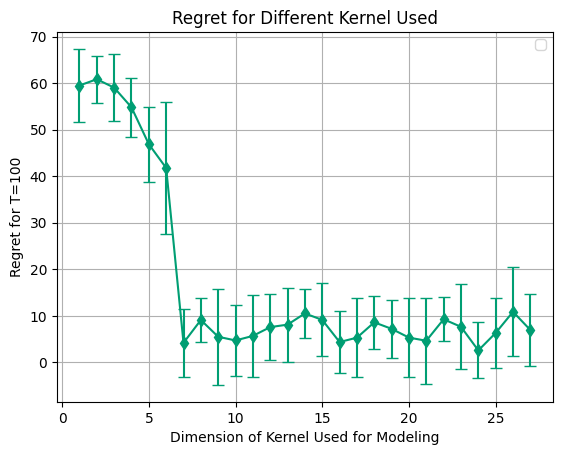

[np.float64(59.51485206642763), np.float64(60.86623129040502), np.float64(59.055581550990865), np.float64(54.823132332164384), np.float64(46.89975175801242), np.float64(41.78046397733143), np.float64(4.182726255099336), np.float64(9.096239244987284), np.float64(5.492487556020595), np.float64(4.699936722046666), np.float64(5.679215756099274), np.float64(7.569336910323977), np.float64(8.099647161403459), np.float64(10.511796483305785), np.float64(9.116334046624674), np.float64(4.358148583935054), np.float64(5.2979349854466955), np.float64(8.597383709378395), np.float64(7.194529713431206), np.float64(5.308515863653994), np.float64(4.636238488452516), np.float64(9.25714934919908), np.float64(7.629183709303018), np.float64(2.5560840075552806), np.float64(6.3142372447313315), np.float64(10.865939754370574), np.float64(6.94362150181482)]
[np.float64(7.866061036436186), np.float64(5.038149260217415), np.float64(7.247884100948871), np.float64(6.349682095713663), np.float64(8.038393120315263), n

In [ ]:
import random

w_random = np.array([1 for _ in range(27)])
w_random = np.random.normal(loc=0.0, scale=sigma_w, size=27)

qubits = 3
seed = 1
bounds = [(0, 2*np.pi), (0, 2*np.pi),(0, 2*np.pi)]

quantum_f = lambda X: np.array([f_draw_from_GP(X[i]) for i in range(X.shape[0])])


dim_tried = []
regret_for_dim = []
std_regret_for_dim = []

for dim in trange(1,28,1, desc="Dimension of Kernel Used"):

  kernell = lambda X,Y: reduced_matrix_classic(X,Y,dim=dim,seed=random.getrandbits(10))

  gp = GaussianProcessRegressor(kernel=kernell, alpha=1e-4)

  avg_best, best_hist_all,std_regret = run_multiple_experiments_gp_ucb(
  f=quantum_f,
  gp=gp,
  bounds=bounds,
  n_runs=30,
  n_iter=100,
  init_points=1,
  n_grid=10,
  beta_func=None,  # use the default inside gp_ucb_nd
  random_state=42,
  error = 6/dim,#get_max_error(dim),
  verbose=False
)

  dim_tried.append(dim)
  regret_for_dim.append(avg_best[-1]/6)
  std_regret_for_dim.append(std_regret[-1]/6)
  print(avg_best)


plt.errorbar(dim_tried,regret_for_dim,std_regret_for_dim,ls="-",
             marker='d',
             color="#009E73",
             alpha=1.0,
             capsize=4)
plt.title("Regret for Different Kernel Used")
plt.xlabel("Dimension of Kernel Used for Modeling")
plt.ylabel("Regret for T=100")
plt.grid(True)
plt.legend()
plt.show()


print(regret_for_dim)
print(std_regret_for_dim)